# Insights from Failed Orders

## Outline

- [Objectives](#objectives)
- [Setup](#setup)
- [Data Exploration](#data-exploration)
- [Highest Number of Failed Orders by Driver Assignment and Order Status](#highest-orders)
- [Hours of Failed Orders by Driver Assignment and Order Status](#failed-hours)
- [Average Time to Cancellation by Driver Assignment and Hour](#average-cancellation)
- [Average Estimated Time before Arrival by Hour](#average-eta-hour)
- [Hexagon Map of Failed Orders](#hex-failed-orders)

## Objectives <a id='objectives'></a>

The following questions will be answered:

1. What were the highest number of orders by driver assignment and order status?
2. Which hours had the most failed orders by driver assignment and order status?
3. What was the average time to cancellation by driver assignment and hour?
4. What was the average estimated time before arrival by hour?
5. Where were the most failed orders coming from?

## Setup <a id='setup'></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import geojson
import h3
import folium

In [2]:
# Read data
orders = pd.read_csv('data/raw/data_orders.csv')
offers = pd.read_csv('data/raw/data_offers.csv')

## Data Exploration <a id='data-exploration'></a>

In [3]:
# Get shape of data
print(f'orders data: {orders.shape[0]} rows, {orders.shape[1]} columns')
print(f'offers data: {offers.shape[0]} rows, {offers.shape[1]} columns')

orders data: 10716 rows, 8 columns
offers data: 334363 rows, 2 columns


In [4]:
# Sample of orders data
orders.sample(n=10)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
7888,02:35:51,-0.970932,51.457899,NaN,3000617025490,4,0,20.0
5040,00:10:34,-0.954270,51.435905,NaN,3000625793229,9,0,NaN
4407,08:52:44,-0.966842,51.472315,NaN,3000632147194,9,0,NaN
3864,09:28:18,-0.944905,51.455477,NaN,3000624790943,4,0,60.0
3661,11:30:22,-0.930618,51.452949,595.0,3000631130912,4,1,33.0
187,23:22:28,-0.972482,51.458324,NaN,3000623168471,4,0,108.0
5015,01:13:39,-0.948888,51.444795,NaN,3000625817928,4,0,130.0
2901,19:27:21,-0.954036,51.422667,656.0,3000590031039,4,1,29.0
9711,15:17:49,-0.949843,51.445623,179.0,3000582966924,4,1,73.0
4491,23:37:32,-0.972939,51.453986,NaN,3000595121466,4,0,11.0


In [5]:
# Sample of offers data
offers.sample(n=10)

,order_gk,offer_id
186032,3000622940791,300051803779
50208,3000628431254,300052136981
146771,3000623167154,300051831923
122557,3000589206863,300051258696
32591,3000627831157,300052106352
328901,3000589956051,300051299505
323627,3000578752081,300050905171
178048,3000595521553,300051534612
62431,3000557786818,300050780227
129019,3000630656096,300052307955


In [6]:
# Merge orders and offers data into one DataFrame on order_gk column for easier analysis
df = orders.merge(right=offers, how='inner', on='order_gk')

In [7]:
# Sample of merged DataFrame
df.sample(n=10)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
5212,23:14:03,-1.012336,51.445050,NaN,3000624467966,4,0,233.0,300051918222
16700,17:49:45,-0.968025,51.456356,NaN,3000627381816,4,0,243.0,300052077989
13580,08:03:37,-0.969088,51.449017,577.0,3000622142036,4,1,961.0,300051753567
26087,09:34:01,-0.978916,51.456173,NaN,3000583491346,9,0,NaN,300051006790
25474,07:58:18,-0.974199,51.475280,298.0,3000592771679,4,1,223.0,300051383440
14234,22:14:38,-0.973992,51.454219,NaN,3000600062403,4,0,159.0,300051693369
26105,21:02:33,-0.968042,51.457997,NaN,3000583766717,9,0,NaN,300051029373
25433,08:00:43,-0.967327,51.449395,958.0,3000592771820,4,1,108.0,300051383690
14125,02:57:22,-0.963129,51.454948,NaN,3000599585722,4,0,44.0,300051668838
27713,17:36:37,-0.970779,51.468122,NaN,3000577401105,4,0,77.0,300050824581


- The `order_status_key` is an enumeration with the following mapping:
    - `4` - cancelled by client,
    - `9` - cancelled by system, i.e., a reject
- The `is_driver_assigned_key` indicates whether a driver has been assigned.
    - `0` will be replaced with `No`
    - `1` will be replaced with `Yes`

In [8]:
# Replace values in order_status_key column with string description
df['order_status_key'] = df['order_status_key'].replace({4: 'Client Cancelled', 9: 'System Reject'})

In [9]:
# Replace values in is_driver_assigned_key column with string description
df['is_driver_assigned_key'] = df['is_driver_assigned_key'].replace({0: 'No', 1: 'Yes'})

In [10]:
# Rename columns
df = df.rename(columns={'order_status_key': 'order_status', 'is_driver_assigned_key': 'is_driver_assigned', 'order_datetime': 'order_time'})

In [11]:
# Create order_hour column
df['order_hour'] = pd.to_datetime(df['order_time'], format='%H:%M:%S').dt.hour

In [12]:
# Sample of processed df
df.sample(n=10)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status,is_driver_assigned,cancellations_time_in_seconds,offer_id,order_hour
2133,01:34:37,-0.957767,51.449294,359.0,3000585240608,Client Cancelled,Yes,57.0,300051109546,1
20972,21:51:38,-0.952001,51.445194,NaN,3000591381397,Client Cancelled,No,258.0,300051352233,21
28892,18:51:44,-0.964464,51.459301,359.0,3000594346835,Client Cancelled,Yes,865.0,300051477424,18
27289,15:36:20,-0.950913,51.448931,NaN,3000629281301,System Reject,No,NaN,300052219330,15
30099,11:35:01,-0.948907,51.444643,60.0,3000590480957,Client Cancelled,Yes,273.0,300051319674,11
1040,11:26:29,-0.891935,51.446036,NaN,3000627880702,Client Cancelled,No,58.0,300052109035,11
16561,17:58:27,-0.947824,51.419584,NaN,3000623692484,Client Cancelled,No,76.0,300051863395,17
23402,22:44:17,-0.950865,51.449670,NaN,3000617527149,Client Cancelled,No,19.0,300051722369,22
20113,14:03:07,-0.951944,51.444863,538.0,3000596171766,Client Cancelled,Yes,60.0,300051557894,14
15820,08:40:24,-0.988891,51.447630,NaN,3000583467936,Client Cancelled,No,187.0,300051001603,8


## Highest Number of Failed Orders by Driver Assignment and Order Status <a id='highest-orders'></a>

The reasons for failed orders are:

- Client cancellations before and after driver assignment
- System rejections before and after driver assignment

Which category had the highest number of orders?

In [13]:
# Group by driver_assigned and order_status then count order_gpk
df_q1 = df.groupby(by=['is_driver_assigned', 'order_status'])['order_gk'].count()
df_q1

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

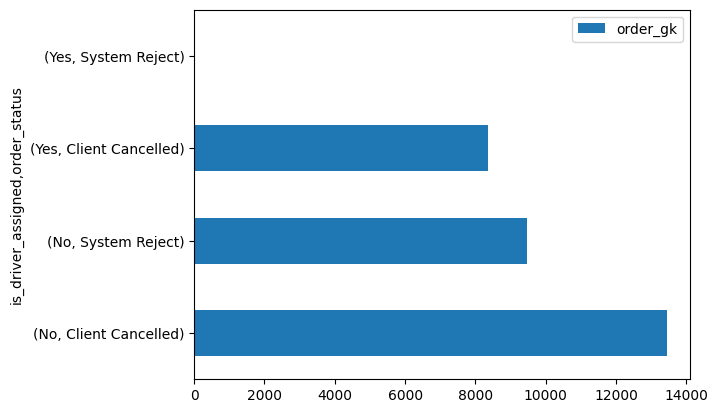

In [14]:
# Plot bar chart
_ = df_q1.plot(kind='barh', legend=True)

In [15]:
# Use pivot_table() method
df_q1_pivot = df.pivot_table(columns=['is_driver_assigned', 'order_status'], values='order_gk', aggfunc='count')
df_q1_pivot

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

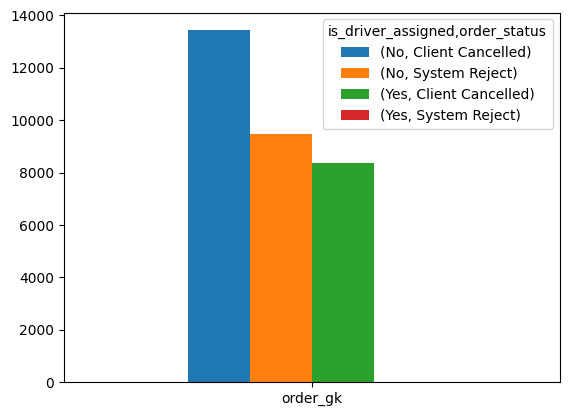

In [16]:
# Plot bar chart
_ = df_q1_pivot.plot(kind='bar', subplots=False, legend=True, rot=0)

- There were a high number of orders cancelled by clients before a driver was assigned.
    - This could indicate clients waited too long and decided on alternative transportation.
- There were 4 system rejections before a driver was assigned.

## Hours of Failed Orders by Driver Assignment and Order Status <a id='failed-hours'></a>

Which hours had the most failed orders by driver assignment and order status?

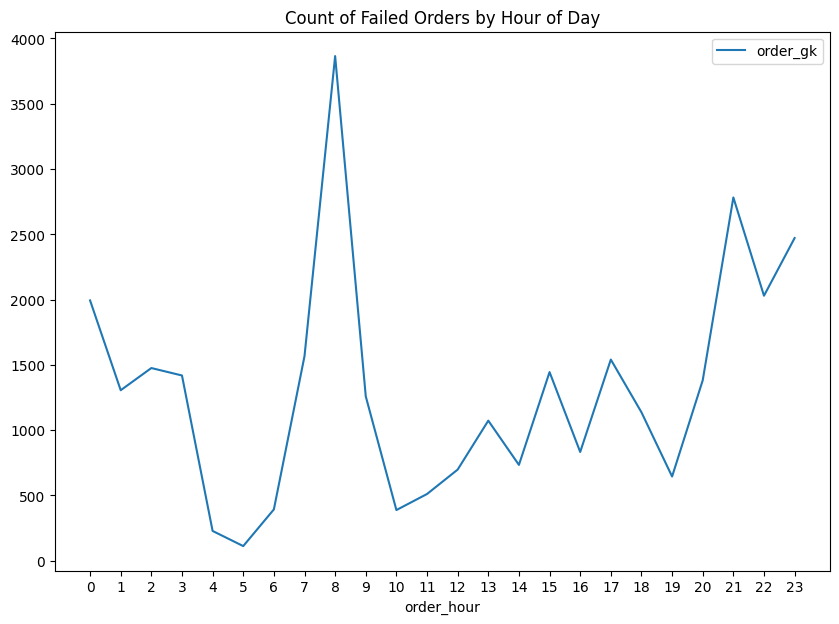

In [17]:
# Plot count of failed orders by hour of day
_ = df.groupby(by='order_hour')['order_gk'].count().plot(figsize=(10, 7), legend=True, xticks=range(0, 24), title='Count of Failed Orders by Hour of Day')

In [18]:
# Group by order_hour, is_driver_assigned, and order_status then count order_gk
df_q2 = df.groupby(by=['order_hour', 'is_driver_assigned', 'order_status'])['order_gk'].count()
df_q2

order_hour  is_driver_assigned  order_status    
0           No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
1           No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

In [19]:
# Use pivot_table() method
df_q2_pivot = df.pivot_table(index='order_hour', columns=['is_driver_assigned', 'order_status'], values='order_gk', aggfunc='count')
df_q2_pivot

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_hour                                                           
0                             957.0         706.0            326.0   
1                             633.0         374.0            298.0   
2                             586.0         649.0            240.0   
3                             565.0         658.0            195.0   
4                              90.0          45.0             92.0   
5                              31.0          33.0             47.0   
6                             169.0         109.0            114.0   
7                             523.0         526.0            517.0   
8                            1447.0        1338.0           1080.0   
9                             470.0         294.0            494.0   
10                            122.0          37.0            228.0   
11                            155.0          65.0            290.0   
12                            321.0          91.0            285.0   
13                            436.0         294.0            342.0   
14                            311.0         125.0            297.0   
15                            610.0         335.0            499.0   
16                            381.0         112.0            339.0   
17                            756.0         319.0            465.0   
18                            447.0         314.0            375.0   
19                            242.0          95.0            307.0   
20                            664.0         371.0            346.0   
21                           1421.0        1036.0            325.0   
22                            954.0         660.0            415.0   
23                           1144.0         883.0            444.0   

is_driver_assigned                
order_status       System Reject  
order_hour                        
0                            4.0  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN  
5                            NaN  
6                            NaN  
7                            NaN  
8                            NaN  
9                            NaN  
10                           NaN  
11                           NaN  
12                           NaN  
13                           NaN  
14                           NaN  
15                           NaN  
16                           NaN  
17                           NaN  
18                           NaN  
19                           NaN  
20                           NaN  
21                           NaN  
22                           NaN  
23                           NaN

- All 4 of the 'System Reject' instances with a driver assigned occurred around midnight.

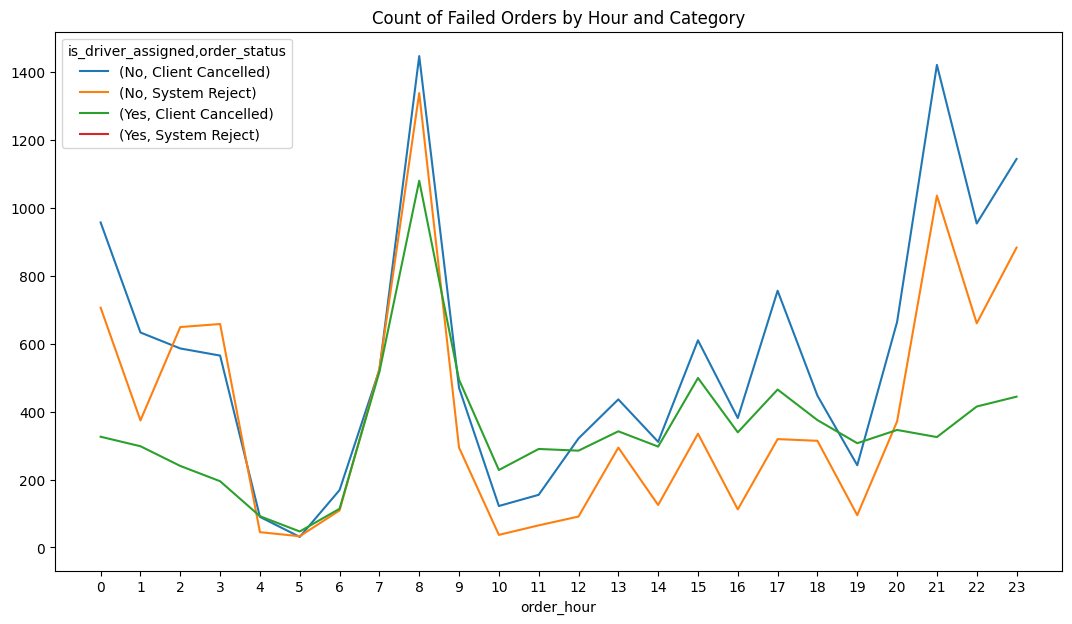

In [20]:
# Plot line chart
_ = df_q2_pivot.plot(figsize=(13, 7), xticks=range(0, 24), title='Count of Failed Orders by Hour and Category')

- Excluding the system rejects with a driver assigned, the remaining categories follow similar distributions.
- There were more client cancellations regardless of a driver assigned around 8 in the morning.
- Without a driver assigned, there were more client cancellations and system rejects around 9 in the evening.
- During night hours, there were less client cancellations with a driver assigned.

## Average Time to Cancellation by Driver Assignment and Hour <a id='average-cancellation'></a>

What was the average time to cancellation by driver assignment and hour?

In [21]:
# Group by order_hour, is_driver_assigned then get mean of cancellations_time_in_seconds
df_q3 = df.groupby(by=['order_hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean()
df_q3

order_hour  is_driver_assigned
0           No                    115.126437
            Yes                   276.082822
1           No                    100.593997
            Yes                   296.312081
2           No                    121.305461
            Yes                   301.466667
3           No                    129.182301
            Yes                   368.682051
4           No                    100.733333
            Yes                   245.250000
5           No                    102.838710
            Yes                   156.617021
6           No                    202.952663
            Yes                   225.508772
7           No                    141.177820
            Yes                   177.640232
8           No                    132.625432
            Yes                   172.896296
9           No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes         

In [22]:
# Use pivot_table() method
df_q3_pivot = df.pivot_table(index='order_hour', columns='is_driver_assigned', values='cancellations_time_in_seconds')
df_q3_pivot

is_driver_assigned,No,Yes
order_hour,,
0,115.126437,276.082822
1,100.593997,296.312081
2,121.305461,301.466667
3,129.182301,368.682051
4,100.733333,245.250000
5,102.838710,156.617021
6,202.952663,225.508772
7,141.177820,177.640232
8,132.625432,172.896296


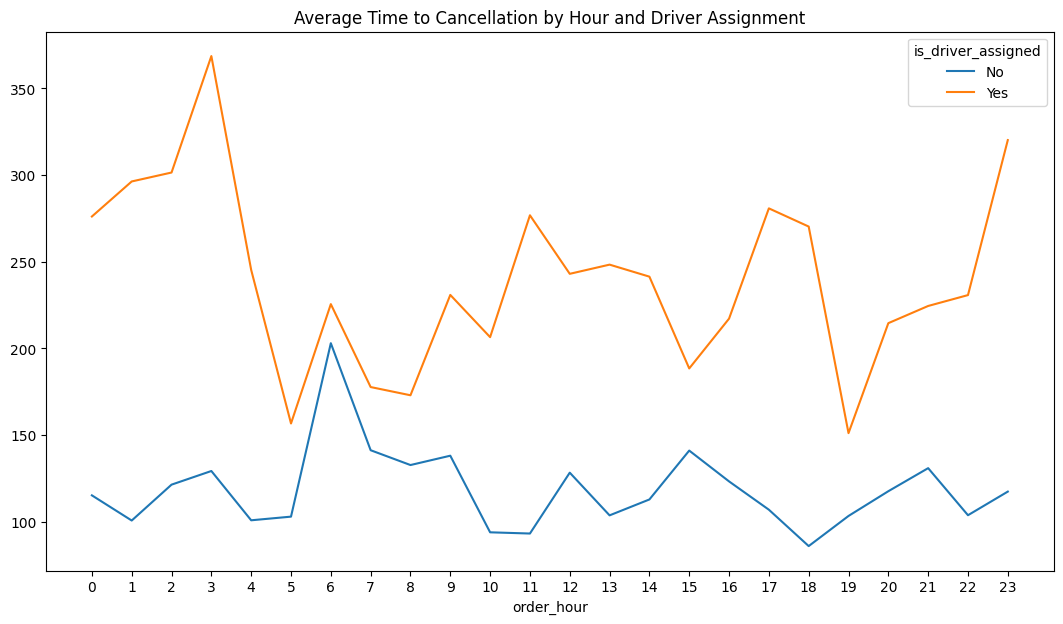

In [23]:
# Plot line chart
_ = df_q3_pivot.plot(figsize=(13, 7), xticks=range(0, 24), title='Average Time to Cancellation by Hour and Driver Assignment')

- For all hours of the day, the average time to cancellation was higher on orders *with* an assigned driver than without an assigned driver.
- There was a peak in client cancellations with an assigned driver at around 3 in the morning.
    - At this time, clients may be less likely to wait for a driver.

## Average Estimated Time before Arrival by Hour <a id='average-eta-hour'></a>

What was the average estimated time before arrival by hour?

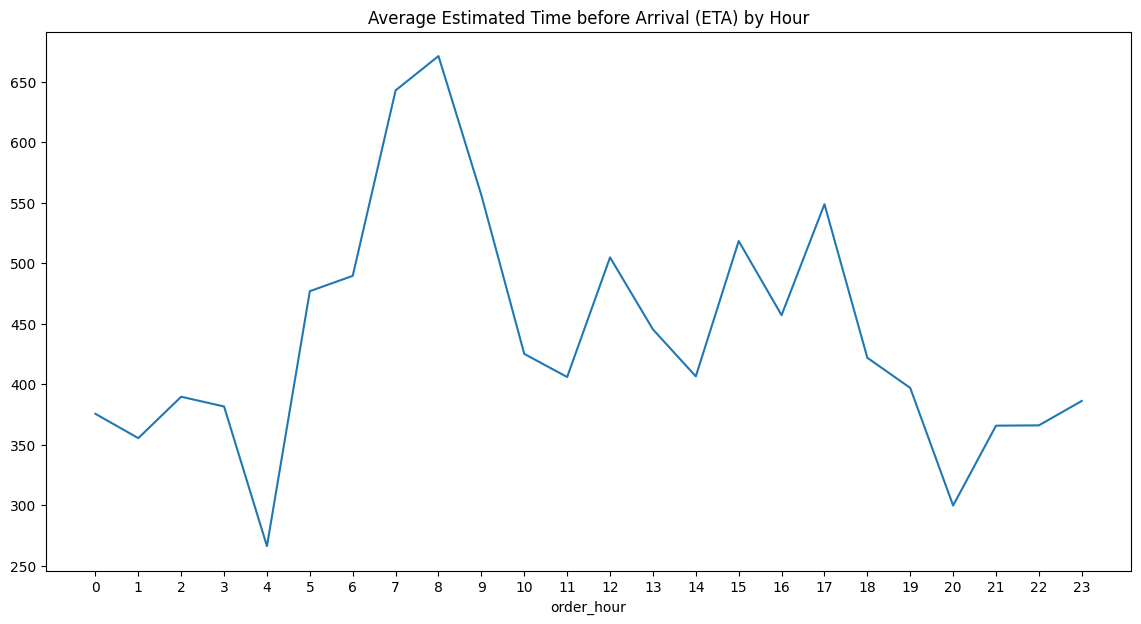

In [24]:
# Group by order_hour then get mean of m_order_eta
# Plot line chart
_ = df.groupby(by='order_hour')['m_order_eta'].mean().plot(figsize=(14, 7), xticks=range(0, 24), title='Average Estimated Time before Arrival (ETA) by Hour')

In [25]:
# Group by order_hour, aggregate order_count and eta_mean
df_q4 = df.groupby(by='order_hour').agg(order_count=('order_gk', 'count'), eta_mean=('m_order_eta', 'mean'))
df_q4

,order_count,eta_mean
order_hour,,
0,1993,375.433333
1,1305,355.322148
2,1475,389.554167
3,1418,381.492308
4,227,266.119565
5,111,476.787234
6,392,489.456140
7,1566,642.746615
8,3865,671.086111


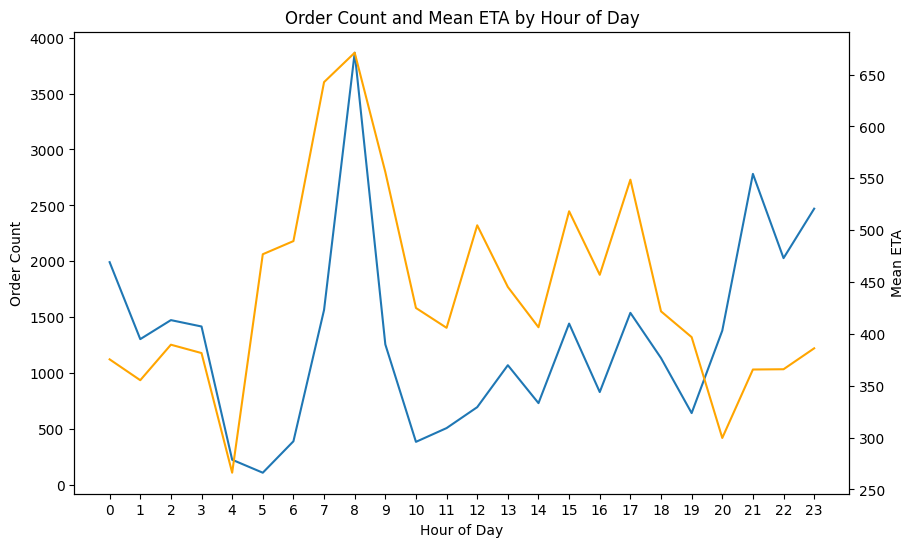

In [26]:
# Plot order_count and eta_mean line chart

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot order_count on first axis
ax.plot(df_q4.index, df_q4['order_count'])
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Order Count')
ax.tick_params(axis='y')
ax.set_xticks(range(0, 24))

# Create second axis to plot eta_mean
ax2 = ax.twinx()
ax2.plot(df_q4.index, df_q4['eta_mean'], color='orange')
ax2.set_ylabel('Mean ETA')
ax2.tick_params(axis='y')

# Set title
plt.title('Order Count and Mean ETA by Hour of Day')

# Show plot
plt.show()

- In general, the line representing mean estimated time before arrival is similar to the line for count of orders.
- This indicates that the number of failed orders increases as the average waiting time of clients increases.

## Hexagon Map of Failed Orders <a id='hex-failed-orders'></a>

How many size 8 hexes contain 80% of all orders from the original data?

In [27]:
# Create hex_id column from latitude and longitude
df['hex_id'] = df.apply(lambda row: h3.geo_to_h3(lat=row['origin_latitude'], lng=row['origin_longitude'], resolution=8), axis=1)

In [28]:
# Group by hex_id, count order_gk
df_q5 = df.groupby(by='hex_id')['order_gk'].count().reset_index()
df_q5

,hex_id,order_gk
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10
3,88195d2807fffff,3
4,88195d2809fffff,46
...,...,...
134,88195d749dfffff,2
135,88195d74d1fffff,1
136,88195d74d3fffff,4
137,88195d74d5fffff,1


In [29]:
# Apply cumulative percentage operation over order_gk count column

# Sort DataFrame by count
df_q5 = df_q5.sort_values(by='order_gk')

# Apply cumsum() method to find cumulative sum of order_gk count colum
df_q5['cumulative_sum'] = df_q5['order_gk'].cumsum()

# Create cumulative_percentages by dividing cumulative_sum by total sum
df_q5['cumulative_percentage'] = df_q5['cumulative_sum'] / df_q5['order_gk'].sum() * 100

# Filter for rows less than or equal to 80%
df_q5[df_q5['cumulative_percentage'] <= 80]

,hex_id,order_gk,cumulative_sum,cumulative_percentage
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


- Here, there are 137 rows after processing compared to 139 rows in the original DataFrame.
- This means 137 hexagons will contain around 80% of data, and only 2 hexagons contain the remaining 20%.

In [30]:
# Create interactive map with folium library
map = folium.Map(location=[df['origin_latitude'].mean(), df['origin_longitude'].mean()], zoom_start=12, tiles='cartodbpositron')

In [31]:
# Define row-wise function to tranform hex_id into GeoJSON object
def to_geojson(row):
    """
    Transform hex_id into a GeoJSON object.
    """
    # Get coordinates for hexagon ID
    coordinates = h3.h3_to_geo_boundary(h=row['hex_id'], geo_json=True)
    
    # Create GeoJSON geometry object with type 'Polygon' and coordinates
    geometry = {
        'type': 'Polygon',
        'coordinates': [coordinates]
    }
    
    # Create GeoJSON feature with properties including hexagon ID and row information
    feature = geojson.Feature(id=row['hex_id'], geometry=geometry, properties={'order_gk': row['order_gk']})
    
    # Return GeoJSON feature representing hexagon
    return feature

In [32]:
# Get JSON-formatted string representing a GeoJSON FeatureCollection

# Apply to_geojson function to DataFrame rows and convert to list
geojsons = df_q5.apply(func=to_geojson, axis=1).values.tolist()

# Create GeoJSON FeatureCollection from list of GeoJSON features
# Convert object into JSON formatted string
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

In [33]:
# Instantiate colormap object
colormap = mpl.colormaps.get_cmap('plasma')

# Calculate maximum value to scale colormap
max_order_gk = df_q5['order_gk'].max()

# Calculate minimum value to scale colormap
min_order_gk = df_q5['order_gk'].min()

In [34]:
# Create interactive map with GeoJSON features colored based on order_gk values
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    'fillColor': mpl.colors.to_hex(
        colormap((f['properties']['order_gk'] - min_order_gk) / (max_order_gk - min_order_gk))
    ),
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0.7
}).add_to(map)

In [35]:
# Display interactive map
map

- Color intensity represents the magnitude of failed orders.

This notebook was inspired by the [Insights from Failed Orders](https://platform.stratascratch.com/data-projects/insights-failed-orders) data project on [StrataScratch](https://www.stratascratch.com/).